# 12-[EfficientNet]Rethinking Model Scaling for Convolutional Neural Networks

[1.Hyper Parameters](#1)

[2.EfficientNet](#2)
 - [2-1.URLs](#2-1)
 - [2-2.Utils](#2-2)
 - [2-3.Load EfficientNet Parameters(Configs)](#2-3)
 - [2-4.SiLU(Swish), DropConnect](#2-4)
 - [2-5.MBConv](#2-5)
 - [2-6.Define EfficientNet](#2-6)

[3.Training](#3)

In [1]:
import re
import os
import cv2
import math
import torch
import albumentations as A
import matplotlib.pyplot as plt

from functools import partial
from collections import namedtuple

from torch import nn
from tqdm import tqdm
from torchsummary import summary
from torch.nn import functional as F
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.hub import tqdm, load_state_dict_from_url as load_url

<a id="1"></a>
## 1.Hyper Parameters

In [2]:
data_dir = "/home/pervinco/Datasets/mammals-classification/data"
save_dir = "./runs/mammal-classification/resnet"
model_name = "efficientnet-b0"
pretrained_weight = True

epochs = 500
batch_size = 64

learning_rate = 0.001
lr_patience = 10
lr_decay_rate = 0.1 ## 0.98
weight_decay = 0.00002

early_stop_counter = 0
early_stop_patience = 30

num_workers = os.cpu_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<a id="2"></a>
## 2.EfficientNet

<a id="2-1"></a>
### 2-1.URLs

In [3]:
model_names = ['efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3', 
               'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7']

url_map = {'efficientnet-b0': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth',
           'efficientnet-b1': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth',
           'efficientnet-b2': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth',
           'efficientnet-b3': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth',
           'efficientnet-b4': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth',
           'efficientnet-b5': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth',
           'efficientnet-b6': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth',
           'efficientnet-b7': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth',}

url_map_advprop = {'efficientnet-b0': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth',
                   'efficientnet-b1': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b1-0f3ce85a.pth',
                   'efficientnet-b2': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b2-6e9d97e5.pth',
                   'efficientnet-b3': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b3-cdd7c0f4.pth',
                   'efficientnet-b4': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b4-44fb3a87.pth',
                   'efficientnet-b5': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b5-86493f6b.pth',
                   'efficientnet-b6': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b6-ac80338e.pth',
                   'efficientnet-b7': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b7-4652b6dd.pth',
                   'efficientnet-b8': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b8-22a8fe65.pth',}

<a id="2-2"></a>
### 2-2.Utils

In [4]:
GlobalParams = namedtuple('GlobalParams', 
    ['width_coefficient', 'depth_coefficient', 'image_size', 'dropout_rate',
     'num_classes', 'batch_norm_momentum', 'batch_norm_epsilon',
     'drop_connect_rate', 'depth_divisor', 'min_depth', 'include_top']
)

# Parameters for an individual model block
BlockArgs = namedtuple('BlockArgs',
    ['num_repeat', 'kernel_size', 'stride', 'expand_ratio',
     'input_filters', 'output_filters', 'se_ratio', 'id_skip']
)

GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)

In [5]:
def load_pretrained_weights(model, model_name, weights_path=None, load_fc=True, advprop=False, verbose=True):
    """
    weight_path에서 사전 훈련된 가중치를 로드하거나 URL을 사용하여 다운로드한다.

    Args:
        model (Module): EfficientNet의 전체 모델.
        model_name (str): EfficientNet의 모델 이름.
        weights_path (None 또는 str):
            str: 로컬 디스크에 있는 사전 훈련된 가중치 파일의 경로.
            None: 인터넷에서 다운로드한 사전 훈련된 가중치 사용.
        load_fc (bool): 모델 끝에 있는 fc 레이어에 대한 사전 훈련된 가중치를 로드할지 여부.
        advprop (bool): advprop으로 훈련된 사전 훈련된 가중치를 로드할지 여부 (weights_path가 None일 때 유효).
    """

    if isinstance(weights_path, str):
        state_dict = torch.load(weights_path)
    else:
        # AutoAugment or Advprop (different preprocessing)
        url_map_ = url_map_advprop if advprop else url_map
        state_dict = load_url(url_map_[model_name])

    if load_fc:
        ret = model.load_state_dict(state_dict, strict=False)
        assert not ret.missing_keys, 'Missing keys when loading pretrained weights: {}'.format(ret.missing_keys)
    else:
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        ret = model.load_state_dict(state_dict, strict=False)
        assert set(ret.missing_keys) == set(
            ['_fc.weight', '_fc.bias']), 'Missing keys when loading pretrained weights: {}'.format(ret.missing_keys)
    assert not ret.unexpected_keys, 'Missing keys when loading pretrained weights: {}'.format(ret.unexpected_keys)

    if verbose:
        print('Loaded pretrained weights for {}'.format(model_name))


In [6]:
class BlockDecoder(object):
    """
    efficientnet blocks_args를 decoding해서 읽을 수 있도록 만든다. dict 타입.
    """

    @staticmethod
    def _decode_block_string(block_string):
        """
        Args:
            block_string (str):'r1_k3_s11_e1_i32_o16_se0.25_noskip'.

        Returns:
            BlockArgs: The namedtuple defined at the top of this file.
        """
        assert isinstance(block_string, str)

        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            num_repeat=int(options['r']),
            kernel_size=int(options['k']),
            stride=[int(options['s'][0])],
            expand_ratio=int(options['e']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            se_ratio=float(options['se']) if 'se' in options else None,
            id_skip=('noskip' not in block_string))

    @staticmethod
    def _encode_block_string(block):
        """
        dict 타입을 string 타입으로 인코딩.
        Args:
            block (namedtuple): A BlockArgs type argument.

        Returns:
            block_string: A String form of BlockArgs. -> 'r1_k3_s11_e1_i32_o16_se0.25_noskip'.
        """
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        """
        여러 개의 string들을 담고 있는 리스트를 입력.
        각각의 string 원소를 dict 타입으로 변환.

        Args:
            string_list (list[str]): A list of strings, each string is a notation of block.

        Returns:
            blocks_args: A list of BlockArgs namedtuples of block args.
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args


    @staticmethod
    def encode(blocks_args):
        """
        Args:
            blocks_args (list[namedtuples]): A list of BlockArgs namedtuples of block args.

        Returns:
            block_strings: A list of strings, each string is a notation of block.
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings

In [7]:
class Conv2dDynamicSamePadding(nn.Conv2d):
    """
    Tensorflow의 Conv2d에서 padding="same"의 기능을 하는 Convolution layer.
    forward 메소드 내에서 입력 텐서의 크기를 기반으로 패딩 값을 동적으로 계산한다.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2


    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)  # change the output size according to stride ! ! !
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)

        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2])
            
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class Conv2dStaticSamePadding(nn.Conv2d):
    """
    이미지 크기를 바탕으로 패딩을 미리 계산하고 저장한다. 이는 입력 이미지 크기가 모델 사용 전에 알려져 있고, 일정할 때 적합함.
    즉, 입력 크기가 고정되어 있고, 미리 알려진 경우에 더 적합하다.
    """

    # With the same calculation as Conv2dDynamicSamePadding

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, stride, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = (image_size, image_size) if isinstance(image_size, int) else image_size
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2,
                                                pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = nn.Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x


def get_same_padding_conv2d(image_size=None):
    """
    Chooses static padding if you have specified an image size, and dynamic padding otherwise.
    Static padding is necessary for ONNX exporting of models.

    Args:
        image_size (int or tuple): Size of the image.

    Returns:
        Conv2dDynamicSamePadding or Conv2dStaticSamePadding.
    """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)

In [8]:
def round_filters(filters, global_params):
    """
    conv layer에서 적용되는 필터의 수를 조정한다.

    Args:
        filters: 계산되어야 할 필터(채널)의 수.
        global_params (namedtuple): Global params of the model.

    Returns:
        new_filters: New filters number after calculating.
    """
    multiplier = global_params.width_coefficient

    if not multiplier:
        ## width_multiplier가 None일 경우 필터를 그대로 반환.
        return filters
    
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    
    filters *= multiplier
    min_depth = min_depth or divisor  ## 최소 깊이가 설정되지 않았다면, 깊이 나누기 값을 사용.
    
    # follow the formula transferred from official TensorFlow implementation
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)

    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor

    return int(new_filters)


def round_repeats(repeats, global_params):
    """
    블록의 반복 횟수를 계산하고 조정.
    Args:
        repeats (int): num_repeat to be calculated.
        global_params (namedtuple): Global params of the model.

    Returns:
        new repeat: New repeat number after calculating.
    """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats

    return int(math.ceil(multiplier * repeats))



def get_width_and_height_from_size(x):
    """
    입력 x로부터 height와 width를 구한다.
    """

    if isinstance(x, int):
        return x, x
    if isinstance(x, list) or isinstance(x, tuple):
        return x
    else:
        raise TypeError()


def calculate_output_image_size(input_image_size, stride):
    """
    Conv2dSamePadding에 stride가 적용됨에 따라 출력 이미지의 크기를 계산하기 위함.(사실상 static padding을 위해 사용됨.)

    Args:
        input_image_size (int, tuple or list): Size of input image.
        stride (int, tuple or list): Conv2d operation's stride.

    Returns:
        output_image_size: A list [H,W].
    """
    if input_image_size is None:
        return None
    
    image_height, image_width = get_width_and_height_from_size(input_image_size)
    stride = stride if isinstance(stride, int) else stride[0]
    image_height = int(math.ceil(image_height / stride))
    image_width = int(math.ceil(image_width / stride))

    return [image_height, image_width] 

<a id="2-3"></a>
### 2-3.Load EfficientNet Parameters(Configs)

In [9]:
def efficientnet_params(model_name):
    """
    efficientnet-b 시리즈에 따라 model scaling 값을 선택함.

    Args:
        model_name (str): Model name to be queried.

    Returns:
        params_dict[model_name]: A (width,depth,res,dropout) tuple.
    """
    params_dict = {
        # Coefficients:   width, depth, resolution, dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
        'efficientnet-b8': (2.2, 3.6, 672, 0.5),
        'efficientnet-l2': (4.3, 5.3, 800, 0.5),
    }

    return params_dict[model_name]


def efficientnet(width_coefficient=None, depth_coefficient=None, image_size=None, dropout_rate=0.2, drop_connect_rate=0.2, num_classes=1000, include_top=True):
    """
    efficientnet-b 시리즈마다 결정되는 block의 구성과 global parameter 값을 가져온다.

    Args:
        width_coefficient (float)
        depth_coefficient (float)
        image_size (int)
        dropout_rate (float)
        drop_connect_rate (float)
        num_classes (int)

        Meaning as the name suggests.

    Returns:
        blocks_args, global_params.
    """

    # Blocks args for the whole model(efficientnet-b0 by default)
    # It will be modified in the construction of EfficientNet Class according to model
    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25',
        'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25',
        'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25',
        'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]

    blocks_args = BlockDecoder.decode(blocks_args)
    """
    BlockArgs(num_repeat=1, kernel_size=3, stride=[1], expand_ratio=1, input_filters=32, output_filters=16, se_ratio=0.25, id_skip=True)
    BlockArgs(num_repeat=2, kernel_size=3, stride=[2], expand_ratio=6, input_filters=16, output_filters=24, se_ratio=0.25, id_skip=True)
    BlockArgs(num_repeat=2, kernel_size=5, stride=[2], expand_ratio=6, input_filters=24, output_filters=40, se_ratio=0.25, id_skip=True)
    BlockArgs(num_repeat=3, kernel_size=3, stride=[2], expand_ratio=6, input_filters=40, output_filters=80, se_ratio=0.25, id_skip=True)
    BlockArgs(num_repeat=3, kernel_size=5, stride=[1], expand_ratio=6, input_filters=80, output_filters=112, se_ratio=0.25, id_skip=True)
    BlockArgs(num_repeat=4, kernel_size=5, stride=[2], expand_ratio=6, input_filters=112, output_filters=192, se_ratio=0.25, id_skip=True)
    BlockArgs(num_repeat=1, kernel_size=3, stride=[1], expand_ratio=6, input_filters=192, output_filters=320, se_ratio=0.25, id_skip=True)
    """

    global_params = GlobalParams(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        image_size=image_size,
        dropout_rate=dropout_rate,

        num_classes=num_classes,
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        drop_connect_rate=drop_connect_rate,
        depth_divisor=8,
        min_depth=None,
        include_top=include_top,
    )

    return blocks_args, global_params


def get_model_params(model_name, override_params):
    """Get the block args and global params for a given model name.

    Args:
        model_name (str): Model's name.
        override_params (dict): A dict to modify global_params.

    Returns:
        blocks_args, global_params
    """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet(width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: {}'.format(model_name))
    
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)

    return blocks_args, global_params

<a id="2-4"></a>
### 2-4.SiLU(Swish), DropConnect

In [10]:
class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)


def drop_connect(inputs, p, training):
    """
    Drop connect.

    Args:
        input (tensor: BCWH): Input of this structure.
        p (float: 0.0~1.0): Probability of drop connection.
        training (bool): The running mode.

    Returns:
        output: Output after drop connection.
    """
    assert 0 <= p <= 1, 'p must be in range of [0,1]'

    if not training:
        return inputs

    batch_size = inputs.shape[0]
    keep_prob = 1 - p

    # generate binary_tensor mask according to probability (p for 0, 1-p for 1)
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)

    output = inputs / keep_prob * binary_tensor
    
    return output

<a id="2-5"></a>
### 2-5.MBConv

In [11]:
class MBConvBlock(nn.Module):
    def __init__(self, block_args, global_params, image_size=None):
        super().__init__()
        
        self._block_args = block_args
        
        self._bn_mom = 1- global_params.batch_norm_momentum
        self._bn_eps = global_params.batch_norm_epsilon

        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1) ## SE rate
        self.id_skip = block_args.id_skip ## use skip connection and drop connect

        ## Inverted Bottleneck - Expansion
        inp = self._block_args.input_filters
        oup = self._block_args.input_filters * self._block_args.expand_ratio ## apply expansion ratio "t" == number of output channels

        if self._block_args.expand_ratio != 1:
            Conv2d = get_same_padding_conv2d(image_size=image_size)
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        ## Inverted Bottleneck - Depthwise Convolution
        k = self._block_args.kernel_size
        s = self._block_args.stride
        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._depthwise_conv = Conv2d(in_channels=oup, out_channels=oup, groups=oup, kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)
        image_size = calculate_output_image_size(image_size, s)

        ## Added Squeeze and Excitation layer, if desired
        if self.has_se:
            Conv2d = get_same_padding_conv2d(image_size=(1, 1))
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        ## Inverted Bottleneck - Pointwise convolution phase
        final_oup = self._block_args.output_filters
        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)
        self._swish = MemoryEfficientSwish()

    def forward(self, inputs, drop_connect_rate=None):
        """MBConvBlock's forward function.

        Args:
            inputs (tensor): Input tensor.
            drop_connect_rate (bool): Drop connect rate (float, between 0 and 1).

        Returns:
            Output of this block after processing.
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._expand_conv(inputs)
            x = self._bn0(x)
            x = self._swish(x)

        x = self._depthwise_conv(x)
        x = self._bn1(x)
        x = self._swish(x)

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_reduce(x_squeezed)
            x_squeezed = self._swish(x_squeezed)
            x_squeezed = self._se_expand(x_squeezed)
            x = torch.sigmoid(x_squeezed) * x

        # Pointwise Convolution
        x = self._project_conv(x)
        x = self._bn2(x)

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            # The combination of skip connection and drop connect brings about stochastic depth.
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x

<a id="2-6"></a>
### 2-6.Define EfficientNet

In [12]:
class EfficientNet(nn.Module):
    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        
        self._global_params = global_params
        self._blocks_args = blocks_args

        ## Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        ## Stage 1
        image_size = global_params.image_size
        Conv2d = get_same_padding_conv2d(image_size=image_size)

        in_channels = 3
        out_channels = round_filters(32, self._global_params)  ## 필터 수를 width_multiplier로 조정.
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)
        image_size = calculate_output_image_size(image_size, 2) ## output의 height, width를 계산.

        ## Stage 2 ~
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:
            ## in_channel과 out_channel의 값을 조정한다.
            block_args = block_args._replace(input_filters=round_filters(block_args.input_filters, self._global_params),
                                             output_filters=round_filters(block_args.output_filters, self._global_params),
                                             num_repeat=round_repeats(block_args.num_repeat, self._global_params))

            self._blocks.append(MBConvBlock(block_args, self._global_params, image_size=image_size)) ## MBConv block 추가.

            ## out_channels를 조정하고 repeats - 1만큼의 block을 추가.
            image_size = calculate_output_image_size(image_size, block_args.stride)
            if block_args.num_repeat > 1:
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=1)

            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params, image_size=image_size))
                # image_size = calculate_output_image_size(image_size, block_args.stride)  # stride = 1

        ## Head(Classifier)
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer(Output Layer)
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        if self._global_params.include_top:
            self._dropout = nn.Dropout(self._global_params.dropout_rate)
            self._fc = nn.Linear(out_channels, self._global_params.num_classes)

        # set activation to memory efficient swish by default
        self._swish = MemoryEfficientSwish()


    def extract_features(self, inputs):
        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)  # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = self._swish(self._bn1(self._conv_head(x)))

        return x


    def forward(self, inputs):
        # Convolution layers
        x = self.extract_features(inputs)

        # Pooling and final linear layer
        x = self._avg_pooling(x)
        if self._global_params.include_top:
            x = x.flatten(start_dim=1)
            x = self._dropout(x)
            x = self._fc(x)

        return x


    @classmethod
    def from_name(cls, model_name, in_channels=3, **override_params):
        """Create an efficientnet model according to name.

        Args:
            model_name (str): Name for efficientnet.
            in_channels (int): Input data's channel number.
            override_params (other key word params):
                Params to override model's global_params.
                Optional key:
                    'width_coefficient', 'depth_coefficient',
                    'image_size', 'dropout_rate',
                    'num_classes', 'batch_norm_momentum',
                    'batch_norm_epsilon', 'drop_connect_rate',
                    'depth_divisor', 'min_depth'

        Returns:
            An efficientnet model.
        """
        cls._check_model_name_is_valid(model_name)

        blocks_args, global_params = get_model_params(model_name, override_params)
        model = cls(blocks_args, global_params) ## 모델을 생성하고, blocks_args, global_params를 전달.
        model._change_in_channels(in_channels)

        return model


    @classmethod
    def from_pretrained(cls, model_name, weights_path=None, advprop=False, in_channels=3, num_classes=1000, **override_params):
        """Create an efficientnet model according to name.

        Args:
            model_name (str): Name for efficientnet.
            weights_path (None or str):
                str: path to pretrained weights file on the local disk.
                None: use pretrained weights downloaded from the Internet.
            advprop (bool):
                Whether to load pretrained weights
                trained with advprop (valid when weights_path is None).
            in_channels (int): Input data's channel number.
            num_classes (int):
                Number of categories for classification.
                It controls the output size for final linear layer.
            override_params (other key word params):
                Params to override model's global_params.
                Optional key:
                    'width_coefficient', 'depth_coefficient',
                    'image_size', 'dropout_rate',
                    'batch_norm_momentum',
                    'batch_norm_epsilon', 'drop_connect_rate',
                    'depth_divisor', 'min_depth'

        Returns:
            A pretrained efficientnet model.
        """
        model = cls.from_name(model_name, num_classes=num_classes, **override_params)
        load_pretrained_weights(model, model_name, weights_path=weights_path, load_fc=(num_classes == 1000), advprop=advprop)
        model._change_in_channels(in_channels)
        return model


    @classmethod
    def _check_model_name_is_valid(cls, model_name):
        """Validates model name.

        Args:
            model_name (str): Name for efficientnet.

        Returns:
            bool: Is a valid name or not.
        """
        if model_name not in model_names:
            raise ValueError('model_name should be one of: ' + ', '.join(model_names))


    def _change_in_channels(self, in_channels):
        """Adjust model's first convolution layer to in_channels, if in_channels not equals 3.

        Args:
            in_channels (int): Input data's channel number.
        """
        if in_channels != 3:
            Conv2d = get_same_padding_conv2d(image_size=self._global_params.image_size)
            out_channels = round_filters(32, self._global_params)
            self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)

<a id="3"></a>
## 3.Training

In [13]:
def build_model(model_name, num_classes=1000, use_pretrained_weight=True):
    if use_pretrained_weight:
        return EfficientNet.from_pretrained(model_name, num_classes=num_classes)
    else:
        return EfficientNet.from_name(model_name, num_classes=num_classes)

In [14]:
classes = sorted(os.listdir(data_dir))
print(classes)

images, labels = [], []
for str_label in classes:
    img_files = os.listdir(f"{data_dir}/{str_label}")
    for file in img_files:
        if file.endswith(".jpg"):
            images.append(f"{data_dir}/{str_label}/{file}")
            labels.append(str_label)

print(f"Num of Classes : {len(classes)}")
print(f"Num of files & labels : {len(images)}, {len(labels)}")
print(images[0])

train_x, valid_x, train_y, valid_y = train_test_split(images, labels, test_size=0.1, shuffle=True, random_state=42)

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

['african_elephant', 'alpaca', 'american_bison', 'anteater', 'arctic_fox', 'armadillo', 'baboon', 'badger', 'blue_whale', 'brown_bear', 'camel', 'dolphin', 'giraffe', 'groundhog', 'highland_cattle', 'horse', 'jackal', 'kangaroo', 'koala', 'manatee', 'mongoose', 'mountain_goat', 'opossum', 'orangutan', 'otter', 'polar_bear', 'porcupine', 'red_panda', 'rhinoceros', 'sea_lion', 'seal', 'snow_leopard', 'squirrel', 'sugar_glider', 'tapir', 'vampire_bat', 'vicuna', 'walrus', 'warthog', 'water_buffalo', 'weasel', 'wildebeest', 'wombat', 'yak', 'zebra']
Num of Classes : 45
Num of files & labels : 13751, 13751
/home/pervinco/Datasets/mammals-classification/data/african_elephant/african_elephant-0125.jpg
12375 12375
1376 1376


In [15]:
class MammalDataset(Dataset):
    def __init__(self, images, labels, classes, mean=None, std=None, augmentation=False):
        self.classes = classes
        self.images = images
        self.labels = labels

        if mean is None:
            mean = (0.485, 0.456, 0.406)

        if std is None:
            std = (0.229, 0.224, 0.225)

        if augmentation:
            self.augmentation = A.Compose([
                A.OneOf([
                    A.Resize(224, 224, p=0.5),
                    A.SmallestMaxSize(max_size=[256, 512], p=0.5)
                ], p=1),
                A.RandomCrop(width=224, height=224),

                A.HorizontalFlip(p=0.4),
                A.RGBShift(p=0.3),

                A.ShiftScaleRotate(p=1.0, shift_limit_x=(-0.06, 0.06), shift_limit_y=(-0.06, 0.06), 
                                   scale_limit=(-0.099, 0.100), 
                                   rotate_limit=(-180, 180), 
                                   interpolation=0, 
                                   border_mode=0, 
                                   value=(0, 0, 0)),
                A.RandomBrightnessContrast(p=1.0, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
                A.AdvancedBlur(p=0.35, blur_limit=(3, 7), 
                               sigmaX_limit=(0.2, 1.0), 
                               sigmaY_limit=(0.2, 1.0), 
                               rotate_limit=(-90, 90), 
                               beta_limit=(0.5, 8.0), 
                               noise_limit=(0.9, 1.1)),

                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ])
        else:
            self.augmentation = A.Compose([
                A.Resize(224, 224, p=1),
                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ])


    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.classes.index(label)

        image = self.augmentation(image=image)["image"]

        return image, label

In [16]:
train_dataset = MammalDataset(train_x, train_y, classes, augmentation=True)
valid_dataset = MammalDataset(valid_x, valid_y, classes, augmentation=False)
train_dataloder = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers)

In [17]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()

    train_cost, train_acc = 0.0, 0.0
    for x, y in tqdm(dataloader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)

        cost = criterion(y_pred, y)
        cost.backward()
        optimizer.step()

        train_cost += cost.item() * x.size(0)

        _, pred_labels = torch.max(y_pred, 1)
        train_acc += (pred_labels == y).sum().item()

    train_cost /= len(dataloader.dataset)
    train_acc /= len(dataloader.dataset)

    return train_cost, train_acc


def valid(model, dataloader, criterion, device):
    model.eval()

    valid_cost, valid_acc = 0.0, 0.0
    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Valid", leave=False):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            cost = criterion(y_pred, y)

            valid_cost += cost.item() * x.size(0)

            _, pred_labels = torch.max(y_pred, 1)
            valid_acc += (pred_labels == y).sum().item()

        valid_cost /= len(dataloader.dataset)
        valid_acc /= len(dataloader.dataset)

    return valid_cost, valid_acc

def lr_lambda(epoch):
    return lr_decay_rate ** epoch

In [18]:
model = build_model(model_name, num_classes=len(classes), use_pretrained_weight=pretrained_weight)
summary(model, input_size=(3, 224, 224), device="cpu")
model = model.to(device)

Loaded pretrained weights for efficientnet-b0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13        

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler = LambdaLR(optimizer, lr_lambda)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_rate, patience=lr_patience, verbose=True)

lrs = []
train_costs, train_accs = [], []
valid_costs, valid_accs = [], []
best_valid_cost = float('inf')
for epoch in range(epochs):
    train_cost, train_acc = train(model, train_dataloder, criterion, optimizer, device)
    valid_cost, valid_acc = valid(model, valid_dataloader, criterion, device)

    if epoch % 10 == 0 or epoch == epochs:
        print(f"Epoch : {epoch} | {epochs}")
        print(f"\tTrain Loss : {train_cost:.4f}, Train Acc : {train_acc:.4f}")
        print(f"\tValid Loss : {valid_cost:.4f}, Valid Acc : {valid_acc:.4f}")

    train_costs.append(train_cost)
    valid_costs.append(valid_cost)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    
    lrs.append(optimizer.param_groups[0]['lr'])
    # scheduler.step()
    scheduler.step(valid_cost)

    ## Early Stopping
    if valid_cost < best_valid_cost:
        best_valid_cost = valid_cost
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping triggered after epoch {epoch} due to no improvement in validation loss")
        break  # Break out of the loop to stop training

Epoch : 0 | 500
	Train Loss : 1.5935, Train Acc : 0.5826
	Valid Loss : 0.6850, Valid Acc : 0.7943


Epoch : 10 | 500
	Train Loss : 0.5508, Train Acc : 0.8411
	Valid Loss : 0.5323, Valid Acc : 0.8568


Epoch : 20 | 500
	Train Loss : 0.4394, Train Acc : 0.8708
	Valid Loss : 0.5108, Valid Acc : 0.8597


Epoch : 30 | 500
	Train Loss : 0.3931, Train Acc : 0.8859
	Valid Loss : 0.4443, Valid Acc : 0.8968
Epoch 00031: reducing learning rate of group 0 to 1.0000e-04.


Epoch : 40 | 500
	Train Loss : 0.2178, Train Acc : 0.9375
	Valid Loss : 0.2948, Valid Acc : 0.9259


Epoch : 50 | 500
	Train Loss : 0.2021, Train Acc : 0.9421
	Valid Loss : 0.2862, Valid Acc : 0.9222


Epoch : 60 | 500
	Train Loss : 0.1834, Train Acc : 0.9472
	Valid Loss : 0.2858, Valid Acc : 0.9259


Epoch 00070: reducing learning rate of group 0 to 1.0000e-05.


Epoch : 70 | 500
	Train Loss : 0.1682, Train Acc : 0.9497
	Valid Loss : 0.2951, Valid Acc : 0.9259


Epoch : 80 | 500
	Train Loss : 0.1562, Train Acc : 0.9552
	Valid Loss : 0.2855, Valid Acc : 0.9288
Epoch 00081: reducing learning rate of group 0 to 1.0000e-06.


Early stopping triggered after epoch 88 due to no improvement in validation loss


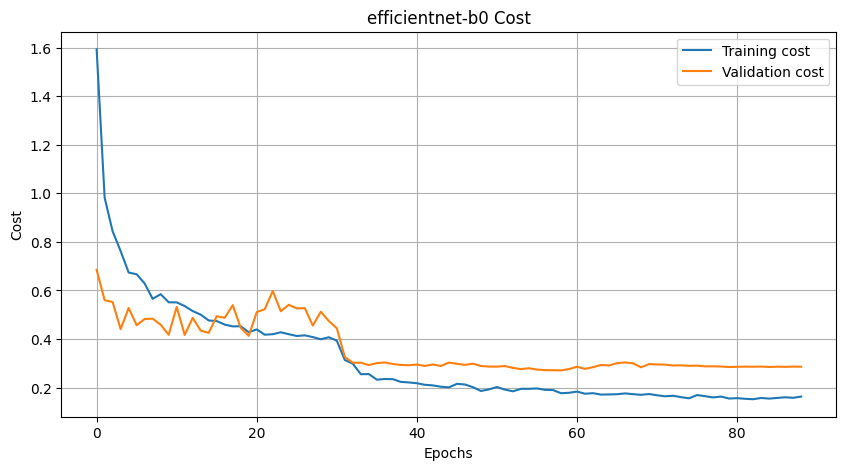

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_costs, label='Training cost')
plt.plot(valid_costs, label='Validation cost')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.title(f'{model_name} Cost')
plt.show()

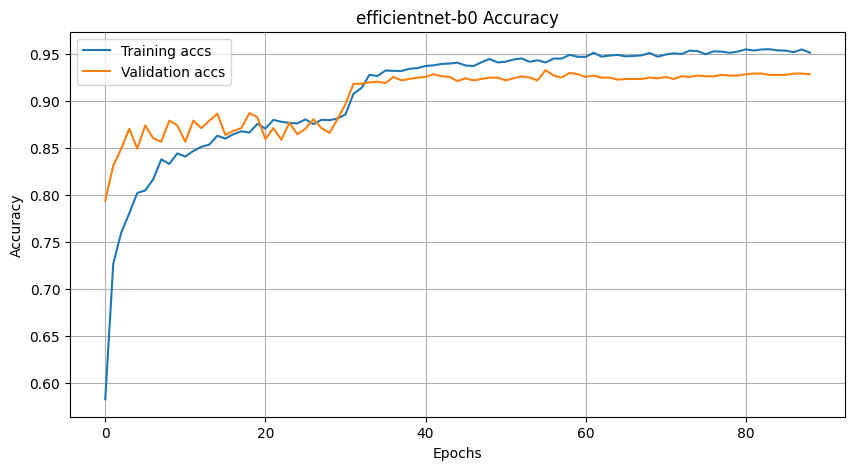

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training accs')
plt.plot(valid_accs, label='Validation accs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title(f'{model_name} Accuracy')
plt.show()

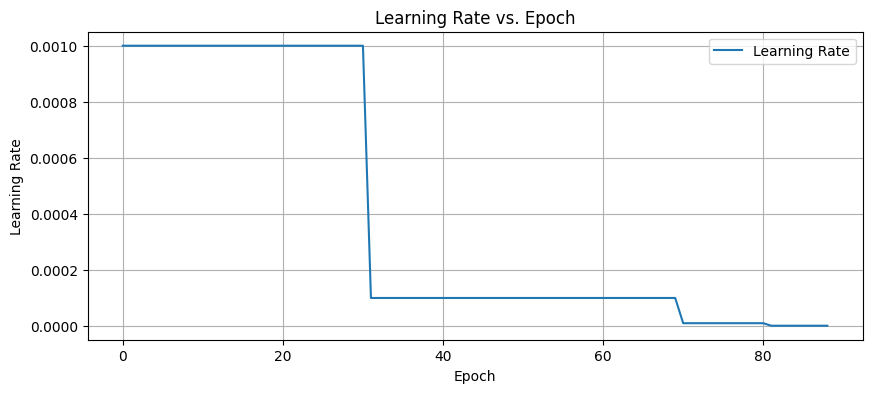

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(lrs, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()